### Notes on Logistic Regression

The data consists of:

- A collection D of N d-dimensional column vectors x (so an 
    (d,N) data matrix) 
    
- A label for each column vector between 0 and k-1 which we represent as an 
    (k,N)
    matrix $L$ such that the jth column has a 1 in the ith row if D[:,j] is in class i,
    and zeroes elsewhere in that column.

The logistic regression model has for parameters a matrix W of size (k,d)
and a bias vector b of
size (k,1). To simplify the notation, let's add a dimension to our column
vectors and set every last value to 1; then we can treat the biases
as part of our matrices W.  From now on our dimension d includes this extra
dimension.


Let $\sigma$ be the softmax function.  The model assigns the multinomial probabilities
$\sigma(Wx)$ to x and we wish to maximize the likelihood of the data given W.  Note that $\sigma(Wx)$  is a (k,1) column vector. 

The relevant loss function is the log-likelihood of the model.  Suppose
that the point $D[:,j]$ belongs to class $i$. Then 

$$
\sum_{j=1}^{N} log\sigma(W[i,:]D[:,j])
$$

In other words, the log-likelihood has a contribution equal to the log of the
probability that the model assigns to point j belonging to its actual class.
We want to maximize this.

To apply gradient descent we need the gradient of the $\log\sigma(Wx)$.
Recall that
$$
(\sigma(WD[:,j]))_i = \frac{e^{W[i,:]D[:,j]}}{Z}
$$
where
$$
Z = \sum_{i=1}^{k} e^{W[i,:]D[:,j]}.
$$

Taking the logarithmic derivative of $\partial_i=\partial/\partial W[i,:]$
gives
$$
\partial_i (\log\sigma(WD[:,k]])_j = -\log\partial_i(Z)
$$
if $j\not=i$ and
$$
\partial_i\log\sigma(WD[:,k])_i = D[:,k]-\log\partial_i(Z)
$$

Using the definition of $Z$ we get
$$
\partial_i\log(Z) = D[:,k](\sigma(WD[:,k])_i
$$


To make sense of these formulas, each term in the sum making up the log likelihood
 -- that is, each data point -- contributes to the gradient.  That contribution
 is $\log\sigma(WD[:,j])_i$ where $i$ is the class to which the point belongs
 The contribution of this term to the gradient in row i is the a multiple
 of the data point:
 $$
 \partial_i = D[:,k](1-(\sigma(WD[:,k])_i)
 $$
 while in other rows the multiple is:
 $$
 \partial_j = -D[:,k](\sigma(WD[:,k])_i)
 $$
 
 Since the probabilities $\sigma(WD[:,k])_i$ are between $0$ and $1$,
 this means that if we follow the gradient the weights in the ith row will 
 be increased a bit while the weights in all the other rows will be
 decreased a bit in the direction of the jth data point if that point belongs to class i.
 
 
 


In [478]:
import numpy as np
from numpy.random import normal
from numpy.random import shuffle
from tqdm import tqdm

Make N points in dim dimensions chosen from two normals at diagonal means 1 and -1.

In [365]:
def setup(npts=100,dim=2):
    N = 100
    dim = 2
    A = normal(1,size=dim*N).reshape(dim,N)
    LA = np.concatenate([np.ones(N).reshape(1,N),np.zeros(N).reshape(1,N)],axis=0)
    B = normal(-1,size=dim*N).reshape(dim,N)
    LB = np.concatenate([np.zeros(N).reshape(1,N),np.ones(N).reshape(1,N)],axis=0)
    D = np.concatenate([A,B],axis=1)
    L = np.concatenate([LA,LB],axis=1)
    D=np.concatenate([D,np.ones(2*N).reshape(1,2*N)])
    W=np.random.normal(size=2*(dim+1)).reshape(2,dim+1)
    return D, L, W

In [366]:
D, L, W = setup(npts=100,dim=2)

In [332]:
def sigma(W,D):
    n = np.exp(np.dot(W,D))
    Z = n.sum(axis=0)
    return n/Z

In [333]:
def loss(W,D,L):
    return (np.log(sigma(W,D))*L).sum()

In [472]:
def gradient(j,W,D,L):
    dim = D.shape[0]
    if L[0,j]==1:
        return np.concatenate([(1-sigma(W,D)[0,j])*D[:,j].reshape(1,dim),-sigma(W,D)[0,j]*D[:,j].reshape(1,dim)])
    else:
        return np.concatenate([-sigma(W,D)[1,j]*D[:,j].reshape(1,dim),(1-sigma(W,D)[1,j])*D[:,j].reshape(1,dim)])

In [494]:
def fit(D, L, W, max_iter=10000,threshold=.001):
    npts = D.shape[1]
    e = 0
    eL = []
    for i in tqdm(range(max_iter)):
        Wsave = W.copy()
        for j in range(npts):
            W = W + .001*gradient(j,Wsave,D,L)
        enew = loss(W,D,L) 
        print(enew)
        if np.abs(e-enew)<.001:
            print("stopping after {} iterations with loss {}".format(i,enew))
            return W, eL
        e = enew
        eL.append(e)
    print("max iterations reached, probably no convergence")
    return W, eL


In [495]:
def error_rate(D, L, W):
    npts = D.shape[1]
    mistakes = 0
    for i in range(npts):
        if (np.argmax(sigma(W,D)[:,i])==0) != (L[0,j]==1):
            mistakes +=1
    return mistakes/npts

In [496]:
import matplotlib.pyplot as plt
D, L, W = setup(100,2)


In [497]:
print(W.shape)

(2, 3)


In [498]:
W, eL = fit(D,L,W)


  0%|          | 0/10000 [00:00<?, ?it/s]

-181.04361219943513
-149.11080078746033
-124.31478732219085
-105.58092730677198
-91.65468321089648
-81.38773183264134
-73.86086387868318
-68.38445252691355
-64.45076016218059
-61.68228480466384
-59.79533847951352


  0%|          | 11/10000 [00:00<01:32, 108.38it/s]

-58.57700065714061
-57.86855631300284
-57.55223931595383
-57.54068512888722
-57.76887132409662
-58.18813735808025
-58.76180928998031
-59.46201425533923
-60.267362683831486
-61.161260310337134
-62.13067716493944


  0%|          | 22/10000 [00:00<01:33, 106.47it/s]

-63.165248596029166
-64.25661789747936
-65.39795486641549
-66.58360240924455
-67.80881618937512
-69.06957171620726
-70.36242020528078
-71.68437966982407
-73.03285149890863


  0%|          | 31/10000 [00:00<01:40, 99.32it/s] 

-74.40555556658678
-75.80047894373966
-77.21583473725191
-78.65002860633689
-80.101631218433
-81.5693553960713
-83.05203703876182
-84.5486191297957
-86.05813829233583


  0%|          | 40/10000 [00:00<01:44, 94.99it/s]

-87.57971346689457
-89.11253635986057
-90.65586337101338
-92.2090087538283
-93.77133880004621
-95.34226687195797
-96.92124913354722
-98.50778085584537
-100.10139319301801


  0%|          | 49/10000 [00:00<01:48, 91.72it/s]

-101.70165034409654
-103.30814703110113
-104.92050623775421
-106.53837716426726
-108.16143336300034
-109.78937102737848
-111.42190741252541
-113.0587793708678
-114.69974198968197
-116.34456732039843


  1%|          | 59/10000 [00:00<01:48, 91.42it/s]

-117.99304319161155
-119.64497209931852
-121.30017016905505
-122.95846618541198
-124.61970068499231
-126.28372510926488
-127.95040101404962
-129.6195993325615
-131.2911996890796
-132.96508976041653


  1%|          | 69/10000 [00:00<01:47, 92.66it/s]

-134.64116468245248
-136.31932649908407
-137.9994836510173
-139.6815505019224
-141.3654468995549
-143.0510977695465
-144.73843273966264
-146.4273857924334
-148.11789494416334
-149.8099019484379


  1%|          | 79/10000 [00:00<01:46, 93.20it/s]

-151.50335202234803
-153.19819359376143
-154.8943780680727
-156.59185961296615
-158.29059495982187
-159.99054322049096
-161.69166571825332
-163.39392583185906
-165.09728885163068
-166.80172184668544


  1%|          | 89/10000 [00:00<01:44, 94.73it/s]

-168.50719354240027
-170.2136742073149
-171.92113554872506
-173.6295506162819
-175.33889371296016
-177.04914031281115
-178.76026698496375
-180.4722513233754
-182.18507188187772
-183.89870811409565
-185.6131403178531


  1%|          | 100/10000 [00:01<01:42, 96.76it/s]

-187.32834958371035
-189.04431774730296
-190.76102734518338
-192.4784615738868
-194.19660425196588
-195.91543978476022
-197.6349531316841
-199.35512977583602
-201.07595569574409
-202.79741733908213
-204.5195015982017


  1%|          | 111/10000 [00:01<01:40, 97.97it/s]

-206.24219578733752
-207.96548762135563
-209.6893651959258
-211.41381696900592
-213.13883174353845
-214.8643986512661
-216.59050713757935
-218.31714694731934
-220.04430811146227
-221.77198093461908
-223.50015598329117


  1%|          | 122/10000 [00:01<01:39, 98.93it/s]

-225.22882407482334
-226.95797626700437
-228.68760384826834
-230.41769832845065
-232.14825143006212
-233.87925508004176
-235.61070140195653
-237.34258270861534
-239.07489149507023
-240.80762043197834
-242.54076235929858


  1%|▏         | 133/10000 [00:01<01:39, 99.29it/s]

-244.27431028030486
-246.00825735589103
-247.74259689915226
-249.47732237022268
-251.2124273713563
-252.9479056422336
-254.6837510554824
-256.419957612399
-258.15651943885916
-259.89343078140706
-261.6306860035129


  1%|▏         | 144/10000 [00:01<01:38, 100.34it/s]

-263.3682795819899
-265.1062061035625
-266.8444602615764
-268.58303685284477
-270.32193077462284
-272.0611370217038
-273.80065068363183
-275.540466942025
-277.2805810680028
-279.0209884197149
-280.7616844399644


  2%|▏         | 155/10000 [00:01<01:38, 100.41it/s]

-282.5026646539231
-284.24392466693337
-285.985460162393
-287.72726689972046
-289.4693407123947
-291.21167750606935
-292.95427325675576
-294.6971240090718
-296.44022587455675
-298.1835750300453
-299.9271677161016


  2%|▏         | 166/10000 [00:01<01:37, 101.10it/s]

-301.67100023550825
-303.4150689518109
-305.1593702879122
-306.90390072471814
-308.6486567998296
-310.3936351062799
-312.13883229131835
-313.8842450552322
-315.6298701502121
-317.37570437925376
-319.12174459509856


  2%|▏         | 177/10000 [00:01<01:37, 100.71it/s]

-320.8679876992079
-322.6144306407739
-324.3610704157603
-326.10790406597755
-327.85492867818454
-329.6021413832233
-331.34953935517746
-333.0971198105604
-334.8448800075273
-336.5928172451107
-338.34092886248254


  2%|▏         | 188/10000 [00:01<01:37, 101.09it/s]

-340.08921223823506
-341.8376647896862
-343.58628397220355
-345.33506727854933
-347.0840122382432
-348.83311641694496
-350.5823774158529
-352.33179287111864
-354.0813604532807
-355.83107786671
-357.580942849072


  2%|▏         | 199/10000 [00:02<01:37, 100.73it/s]

-359.3309531708027
-361.08110663459706
-362.8314010749117
-364.5818343574793
-366.3324043788346
-368.08310906585285
-369.8339463752967
-371.58491429337676
-373.3360108353204
-375.08723404494924
-376.8385819942681


  2%|▏         | 210/10000 [00:02<01:37, 100.87it/s]

-378.59005278306137
-380.3416445384977
-382.0933554147433
-383.8451835925829
-385.5971272790487
-387.3491847070561
-389.10135413504514
-390.85363384663117
-392.6060221502595
-394.3585173788678
-396.11111788955316


  2%|▏         | 221/10000 [00:02<01:40, 97.77it/s] 

-397.8638220632462
-399.6166283043897
-401.36953504062217
-403.12254072246776
-404.8756438230308
-406.62884283769364
-408.3821362838208
-410.13552270046694
-411.8890006480889
-413.6425687082627


  2%|▏         | 231/10000 [00:02<01:44, 93.81it/s]

-415.39622548340304
-417.14996959648863
-418.9037996907891
-420.6577144295983
-422.4117124959685
-424.16579259244975
-425.9199534408317
-427.6741937818902
-429.4285123751347
-431.18290799856095


  2%|▏         | 241/10000 [00:02<01:42, 95.44it/s]

-432.93737944840564
-434.69192553890457
-436.44654510205294
-438.20123698736967
-439.9560000616638
-441.7108332088035
-443.46573532948787
-445.2207053410219
-446.9757421770937
-448.73084478755413


  3%|▎         | 251/10000 [00:02<01:41, 95.64it/s]

-450.4860121381984
-452.24124321055183
-453.99653700165607
-455.75189252385996
-457.5073088046094
-459.26278488624325
-461.01831982578926
-462.7739126947629
-464.5295625789683
-466.28526857830207


  3%|▎         | 261/10000 [00:02<01:41, 95.85it/s]

-468.0410298065581
-469.7968453912351
-471.5527144733471
-473.30863620723517
-475.0646097603805
-476.8206343132217
-478.5767090589726
-480.3328332034422
-482.0890059648566
-483.84522657368404


  3%|▎         | 271/10000 [00:02<01:40, 96.66it/s]

-485.6014942724612
-487.35780831562056
-489.1141679693211
-490.8705725112809
-492.62702123060984
-494.3835134276475
-496.1400484137998
-497.89662551137894
-499.65324405344523
-501.40990338365117


  3%|▎         | 281/10000 [00:02<01:40, 96.81it/s]

-503.1666028560857
-504.9233418351226
-506.6801196952687
-508.4369358210151
-510.19378960669053
-511.95068045631444
-513.707607783454
-515.4645710110826
-517.2215695714387
-518.9786029058877
-520.735670464785


  3%|▎         | 292/10000 [00:03<01:39, 97.83it/s]

-522.4927717073414
-524.2499061014889
-526.00707312375
-527.764272259107
-529.5215030008733
-531.2787648505677
-533.0360573177887
-534.7933799200907
-536.5507321828633
-538.3081136392093
-540.0655238298276


  3%|▎         | 303/10000 [00:03<01:37, 99.01it/s]

-541.8229623028951
-543.5804286139514
-545.3379223257854
-547.0954430083216
-548.8529902385108
-550.6105636002184
-552.3681626841178
-554.1257870875837
-555.8834364145875
-557.6411102755925
-559.3988082874527


  3%|▎         | 314/10000 [00:03<01:37, 99.40it/s]

-561.1565300733112
-562.9142752625017
-564.67204349045
-566.4298343985776
-568.1876476342063
-569.9454828504643
-571.7033397061939
-573.4612178658601
-575.2191169994605
-576.977036782437


  3%|▎         | 324/10000 [00:03<01:38, 98.71it/s]

-578.7349768955883
-580.4929370249835
-582.2509168618782
-584.0089161026297
-585.7669344486155
-587.5249716061516
-589.2830272864132
-591.0411012053555
-592.7991930836362
-594.5573026465382


  3%|▎         | 334/10000 [00:03<01:38, 98.19it/s]

-596.3154296238961
-598.0735737500204
-599.831734763625
-601.5899124077562
-603.3481064297191
-605.1063165810109
-606.8645426172511
-608.6227842981127
-610.3810413872575
-612.1393136522685


  3%|▎         | 344/10000 [00:03<01:40, 96.01it/s]

-613.8976008645859
-615.655902799445
-617.4142192358116
-619.1725499563213
-620.9308947472189
-622.6892533982975
-624.447625702842
-626.2060114575678
-627.9644104625675
-629.7228225212522
-631.481247440297


  4%|▎         | 355/10000 [00:03<01:38, 97.47it/s]

-633.2396850295875
-634.9981351021645
-636.7565974741736
-638.5150719648118
-640.273558396277
-642.0320565937185
-643.790566385186
-645.5490876015829
-647.3076200766177
-649.0661636467565
-650.8247181511776


  4%|▎         | 366/10000 [00:03<01:37, 98.53it/s]

-652.5832834317262
-654.3418593328676
-656.100445701646
-657.8590423876394
-659.6176492429173
-661.3762661219992
-663.1348928818123
-664.8935293816528
-666.6521754831438
-668.4108310501974
-670.1694959489766


  4%|▍         | 377/10000 [00:03<01:36, 99.27it/s]

-671.9281700478555
-673.6868532173834
-675.4455453302476
-677.2042462612374
-678.9629558872086
-680.7216740870488
-682.4804007416415
-684.2391357338347
-685.9978789484059
-687.75663027203


  4%|▍         | 387/10000 [00:03<01:36, 99.42it/s]

-689.5153895932476
-691.2741568024326
-693.0329317917613
-694.7917144551825
-696.5505046883866
-698.309302388777
-700.06810745544
-701.826919789117
-703.585739292176
-705.3445658685844
-707.1033994238813


  4%|▍         | 398/10000 [00:04<01:35, 100.34it/s]

-708.8622398651514
-710.6210871009987
-712.3799410415202
-714.1388015982805
-715.8976686842879
-717.6565422139688
-719.4154221031444
-721.174308269006
-722.933200630093
-724.6920991062691
-726.4510036186996


  4%|▍         | 409/10000 [00:04<01:35, 100.38it/s]

-728.2099140898304
-729.968830443365
-731.7277526042438
-733.4866804986237
-735.2456140538554
-737.0045531984649
-738.7634978621338
-740.5224479756786
-742.2814034710307
-744.04036428122
-745.7993303403539


  4%|▍         | 420/10000 [00:04<01:35, 100.39it/s]

-747.5583015835999
-749.3172779471678
-751.0762593682912
-752.8352457852114
-754.594237137159
-756.3532333643375
-758.1122344079075
-759.8712402099695
-761.6302507135488
-763.3892658625784
-765.1482856018855


  4%|▍         | 431/10000 [00:04<01:36, 98.73it/s] 

-766.9073098771747
-768.6663386350147
-770.4253718228215
-772.1844093888462
-773.9434512821604
-775.7024974526407
-777.4615478509567
-779.2206024285567
-780.9796611376559
-782.7387239312211
-784.4977907629609


  4%|▍         | 442/10000 [00:04<01:36, 99.11it/s]

-786.2568615873099
-788.0159363594189
-789.7750150351417
-791.5340975710242
-793.293183924291
-795.0522740528352
-796.8113679152068
-798.5704654706019
-800.3295666788517
-802.088671500411
-803.8477798963484


  5%|▍         | 453/10000 [00:04<01:35, 99.58it/s]

-805.6068918283361
-807.3660072586395
-809.1251261501068
-810.8842484661602
-812.6433741707845
-814.4025032285199
-816.1616356044509
-817.9207712641976
-819.679910173907
-821.4390523002445
-823.1981976103832


  5%|▍         | 464/10000 [00:04<01:35, 100.02it/s]

-824.9573460719985
-826.7164976532567
-828.475652322809
-830.234810049782
-831.99397080377
-833.753134554828
-835.5123012734622
-837.2714709306242
-839.0306434977035
-840.7898189465186
-842.5489972493112


  5%|▍         | 475/10000 [00:04<01:35, 100.22it/s]

-844.3081783787385
-846.0673623078671
-847.8265490101649
-849.5857384594952
-851.3449306301106
-853.1041254966453
-854.863323034109
-856.6225232178818
-858.3817260237072
-860.1409314276847
-861.9001394062674


  5%|▍         | 486/10000 [00:04<01:34, 100.46it/s]

-863.659349936252
-865.4185629947763
-867.1777785593117
-868.9369966076586
-870.6962171179405
-872.455440068599
-874.2146654383878
-875.9738932063683
-877.7331233519044
-879.4923558546571
-881.2515906945804


  5%|▍         | 497/10000 [00:05<01:34, 100.93it/s]

-883.010827851915
-884.7700673071854
-886.5293090411938
-888.2885530350155
-890.0477992699962
-891.8070477277453
-893.5662983901327
-895.3255512392848
-897.0848062575792
-898.8440634276417
-900.6033227323414


  5%|▌         | 508/10000 [00:05<01:34, 100.72it/s]

-902.3625841547871
-904.1218476783239
-905.8811132865278
-907.640380963204
-909.3996506923811
-911.1589224583087
-912.9181962454538
-914.6774720384968
-916.4367498223274
-918.1960295820435
-919.9553113029446


  5%|▌         | 519/10000 [00:05<01:34, 100.60it/s]

-921.7145949705309
-923.4738805704999
-925.2331680887419
-926.9924575113376
-928.7517488245553
-930.5110420148471
-932.270337068847
-934.029633973367
-935.7889327153948
-937.5482332820905
-939.3075356607835


  5%|▌         | 530/10000 [00:05<01:34, 100.44it/s]

-941.0668398389722
-942.8261458043172
-944.5854535446421
-946.3447630479288
-948.1040743023169
-949.8633872960996
-951.6227020177216
-953.3820184557767
-955.1413365990056
-956.9006564362941
-958.6599779566691


  5%|▌         | 541/10000 [00:05<01:34, 100.03it/s]

-960.4193011492978
-962.1786260034854
-963.9379525086723
-965.6972806544319
-967.4566104304688
-969.2159418266172
-970.9752748328378
-972.7346094392165
-974.4939456359624
-976.2532834134058
-978.0126227619957


  6%|▌         | 552/10000 [00:05<01:34, 100.07it/s]

-979.7719636722982
-981.5313061349957
-983.2906501408836
-985.0499956808692
-986.80934274597
-988.5686913273119
-990.3280414161269
-992.0873930037524
-993.8467460816294
-995.6061006412999
-997.3654566744062


  6%|▌         | 563/10000 [00:05<01:35, 98.97it/s] 

-999.1248141726899
-1000.884173127988
-1002.6435335322346
-1004.4028953774568
-1006.1622586557746
-1007.9216233593997
-1009.6809894806319
-1011.4403570118604
-1013.1997259455611
-1014.9590962742961


  6%|▌         | 573/10000 [00:05<01:35, 98.91it/s]

-1016.7184679907108
-1018.4778410875338
-1020.2372155575754
-1021.9965913937266
-1023.7559685889571
-1025.515347136315


/Users/jteitelbaum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/jteitelbaum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


nan
nan
nan
nan


  6%|▌         | 583/10000 [00:05<01:36, 97.51it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  6%|▌         | 593/10000 [00:06<01:36, 97.85it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  6%|▌         | 603/10000 [00:06<01:36, 97.33it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  6%|▌         | 613/10000 [00:06<01:36, 97.47it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  6%|▌         | 623/10000 [00:06<01:38, 95.50it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  6%|▋         | 633/10000 [00:06<01:38, 95.16it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  6%|▋         | 643/10000 [00:06<01:38, 95.37it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 653/10000 [00:06<01:37, 95.87it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 663/10000 [00:06<01:37, 95.97it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 673/10000 [00:06<01:37, 96.12it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 683/10000 [00:06<01:36, 96.93it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 693/10000 [00:07<01:35, 97.42it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 703/10000 [00:07<01:34, 97.95it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 713/10000 [00:07<01:35, 97.22it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 723/10000 [00:07<01:35, 96.87it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 733/10000 [00:07<01:35, 97.26it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|▋         | 743/10000 [00:07<01:35, 97.41it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 753/10000 [00:07<01:35, 96.74it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 763/10000 [00:07<01:37, 94.85it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 773/10000 [00:07<01:38, 93.83it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 783/10000 [00:08<01:38, 93.38it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 793/10000 [00:08<01:37, 94.21it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 803/10000 [00:08<01:36, 95.48it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 813/10000 [00:08<01:38, 93.41it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 823/10000 [00:08<01:41, 90.75it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 833/10000 [00:08<01:41, 90.08it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|▊         | 843/10000 [00:08<01:40, 91.14it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▊         | 853/10000 [00:08<01:41, 90.46it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▊         | 863/10000 [00:08<01:39, 91.98it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▊         | 873/10000 [00:08<01:39, 91.83it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▉         | 883/10000 [00:09<01:40, 90.48it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▉         | 893/10000 [00:09<01:40, 90.65it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▉         | 903/10000 [00:09<01:41, 89.28it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▉         | 913/10000 [00:09<01:41, 89.70it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▉         | 922/10000 [00:09<01:41, 89.30it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▉         | 932/10000 [00:09<01:38, 91.81it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|▉         | 942/10000 [00:09<01:39, 90.91it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|▉         | 952/10000 [00:09<01:45, 85.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|▉         | 961/10000 [00:10<01:47, 83.88it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|▉         | 970/10000 [00:10<01:47, 84.07it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|▉         | 980/10000 [00:10<01:43, 87.53it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|▉         | 990/10000 [00:10<01:40, 89.64it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|█         | 1000/10000 [00:10<01:38, 91.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|█         | 1010/10000 [00:10<01:35, 93.79it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|█         | 1020/10000 [00:10<01:35, 94.02it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|█         | 1030/10000 [00:10<01:36, 92.58it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|█         | 1040/10000 [00:10<01:37, 92.02it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|█         | 1050/10000 [00:10<01:37, 92.05it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█         | 1060/10000 [00:11<01:36, 93.07it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█         | 1070/10000 [00:11<01:35, 93.69it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█         | 1080/10000 [00:11<01:36, 92.64it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█         | 1090/10000 [00:11<01:35, 92.95it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█         | 1100/10000 [00:11<01:36, 91.97it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█         | 1110/10000 [00:11<01:36, 92.02it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█         | 1120/10000 [00:11<01:36, 92.33it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█▏        | 1130/10000 [00:11<01:36, 91.51it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 11%|█▏        | 1140/10000 [00:11<01:36, 91.46it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1150/10000 [00:12<01:37, 90.37it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1160/10000 [00:12<01:37, 90.72it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1170/10000 [00:12<01:37, 90.45it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1180/10000 [00:12<01:39, 88.97it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1189/10000 [00:12<01:39, 88.96it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1199/10000 [00:12<01:37, 90.53it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1209/10000 [00:12<01:36, 91.16it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1219/10000 [00:12<01:34, 92.45it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1230/10000 [00:12<01:32, 94.81it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█▏        | 1241/10000 [00:13<01:30, 96.29it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1251/10000 [00:13<01:31, 95.36it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1261/10000 [00:13<01:30, 96.50it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1271/10000 [00:13<01:29, 97.42it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1281/10000 [00:13<01:29, 97.25it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1291/10000 [00:13<01:29, 96.78it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1301/10000 [00:13<01:29, 97.15it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1311/10000 [00:13<01:29, 96.97it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1321/10000 [00:13<01:29, 96.86it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1331/10000 [00:13<01:29, 96.87it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 13%|█▎        | 1341/10000 [00:14<01:29, 96.74it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 14%|█▎        | 1351/10000 [00:14<01:29, 96.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 14%|█▎        | 1361/10000 [00:14<01:29, 96.01it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 14%|█▎        | 1371/10000 [00:14<01:30, 95.84it/s]

nan
nan
nan
nan
nan
nan


/Users/jteitelbaum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


nan
nan
nan
nan


 14%|█▍        | 1381/10000 [00:14<01:29, 96.62it/s]

nan


KeyboardInterrupt: 

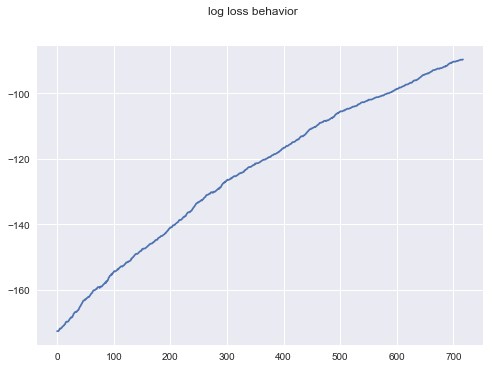

In [432]:
_=plt.plot(range(len(eL)),eL)
_=plt.suptitle('log loss behavior')

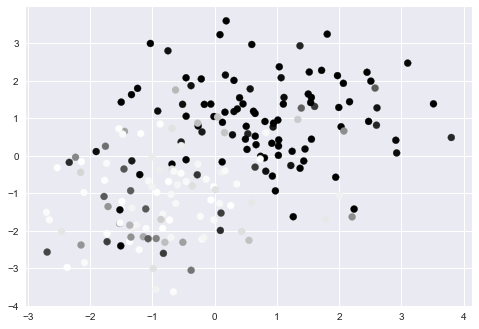

In [425]:
plt.style.use('seaborn')
plt.scatter(x=D[0,:],y=D[1,:],c=P[0,:])

In [357]:
B = (W[0,:]-W[1,:])

In [359]:
B/B[1]

array([0.59697996, 1.        , 0.61008918])

In [363]:
x = np.linspace(-6,6,100)
y = -.5969*x-.610

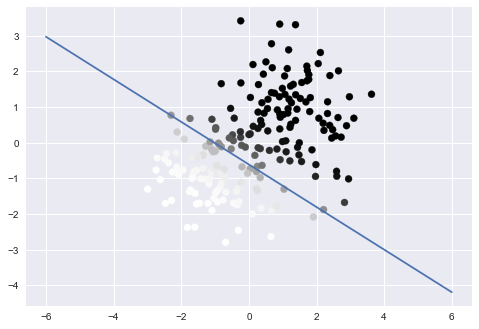

In [364]:
plt.scatter(x=D[0,:],y=D[1,:],c=P[0,:])
plt.plot(x,y)